## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OutputCodeClassifier, OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, balanced_accuracy_score, matthews_corrcoef

from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## Load the Dataset

In [2]:
df = pd.read_csv('predictive_maintenance.csv')

# Display basic info
print(df.info())

# Show first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


## Data Preprocessing

In [3]:
# Drop unnecessary columns
df.drop(['Product ID', 'UDI', 'Target', 'Type'], axis=1, inplace=True)

# Check for missing values
print("Any missing values?", df.isnull().values.any())

# Show dataset after dropping columns
df.head()


Any missing values? False


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,298.1,308.6,1551,42.8,0,No Failure
1,298.2,308.7,1408,46.3,3,No Failure
2,298.1,308.5,1498,49.4,5,No Failure
3,298.2,308.6,1433,39.5,7,No Failure
4,298.2,308.7,1408,40.0,9,No Failure


## Data Visualisation

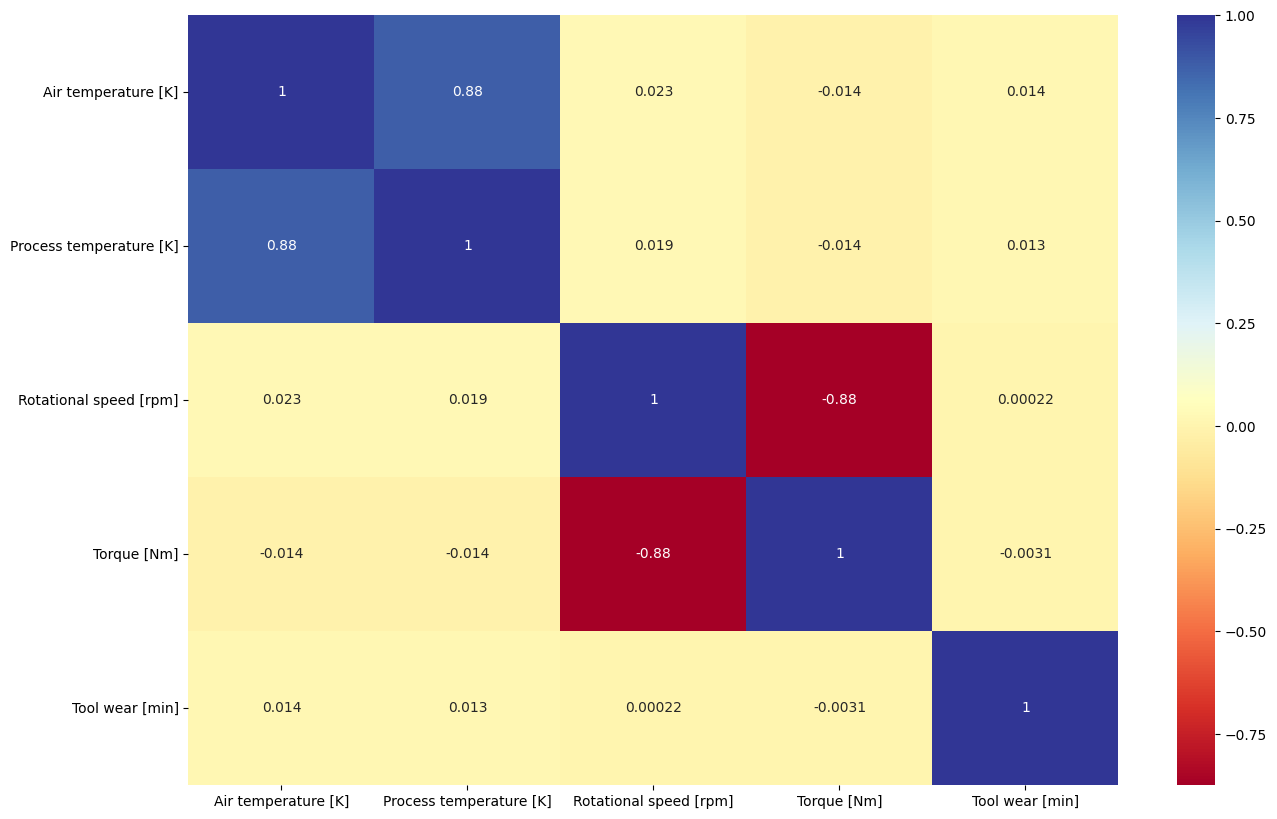

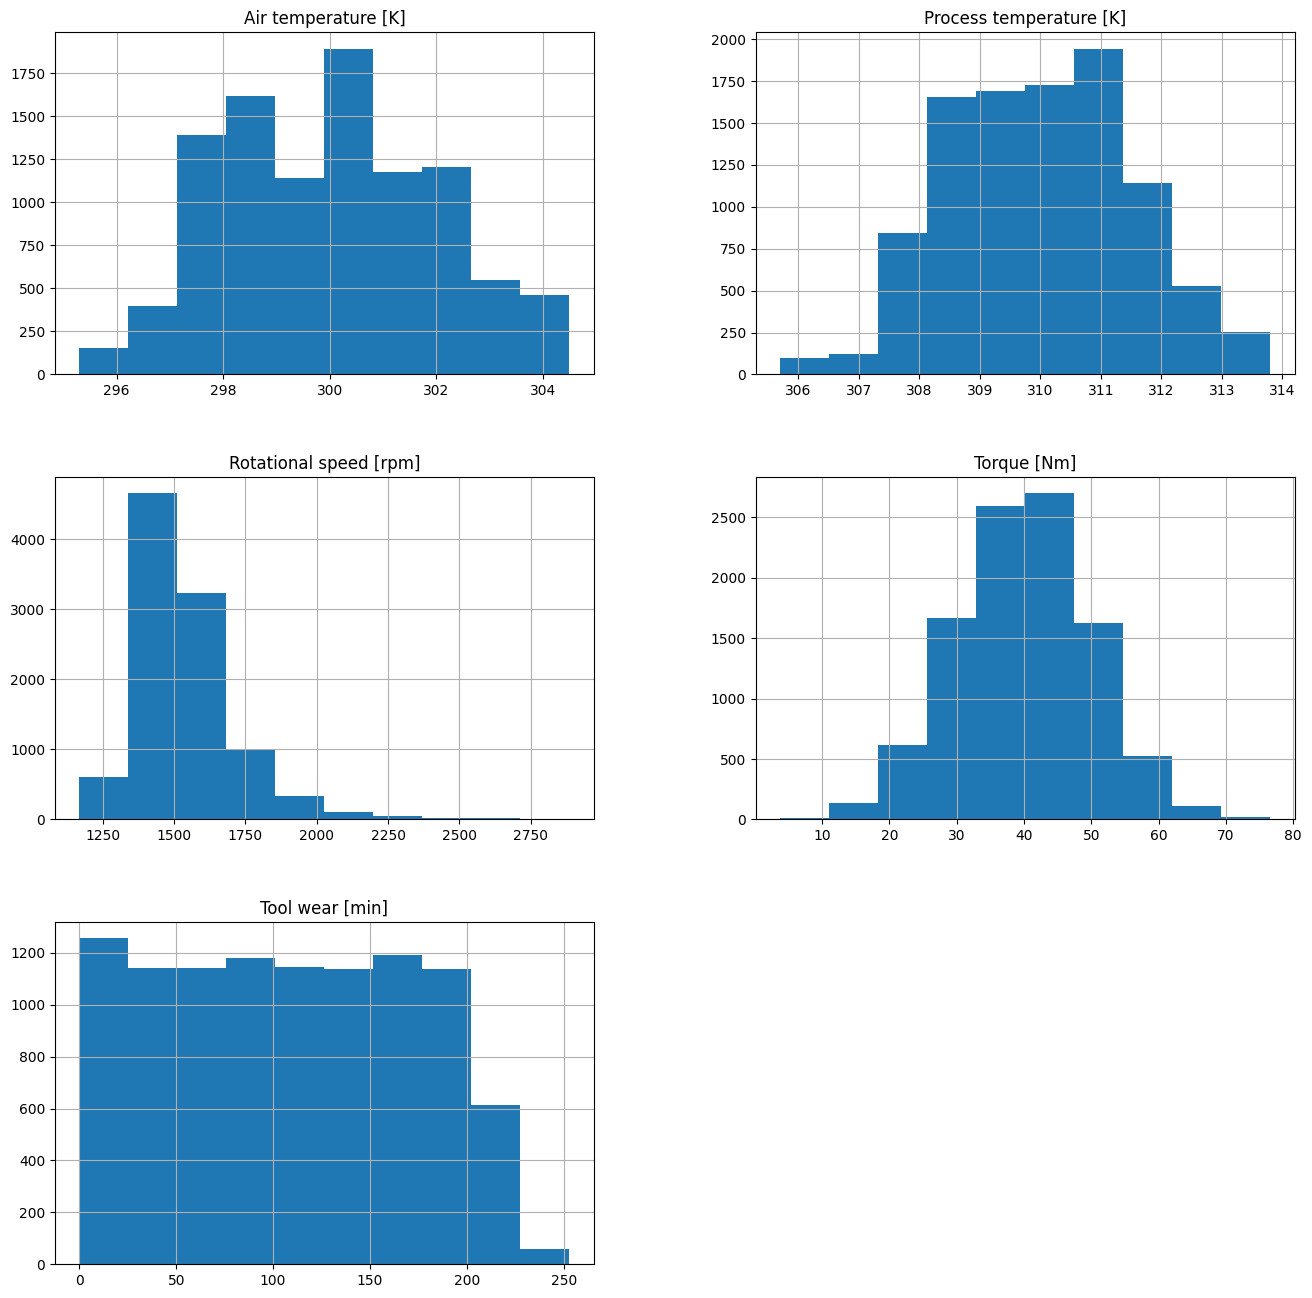

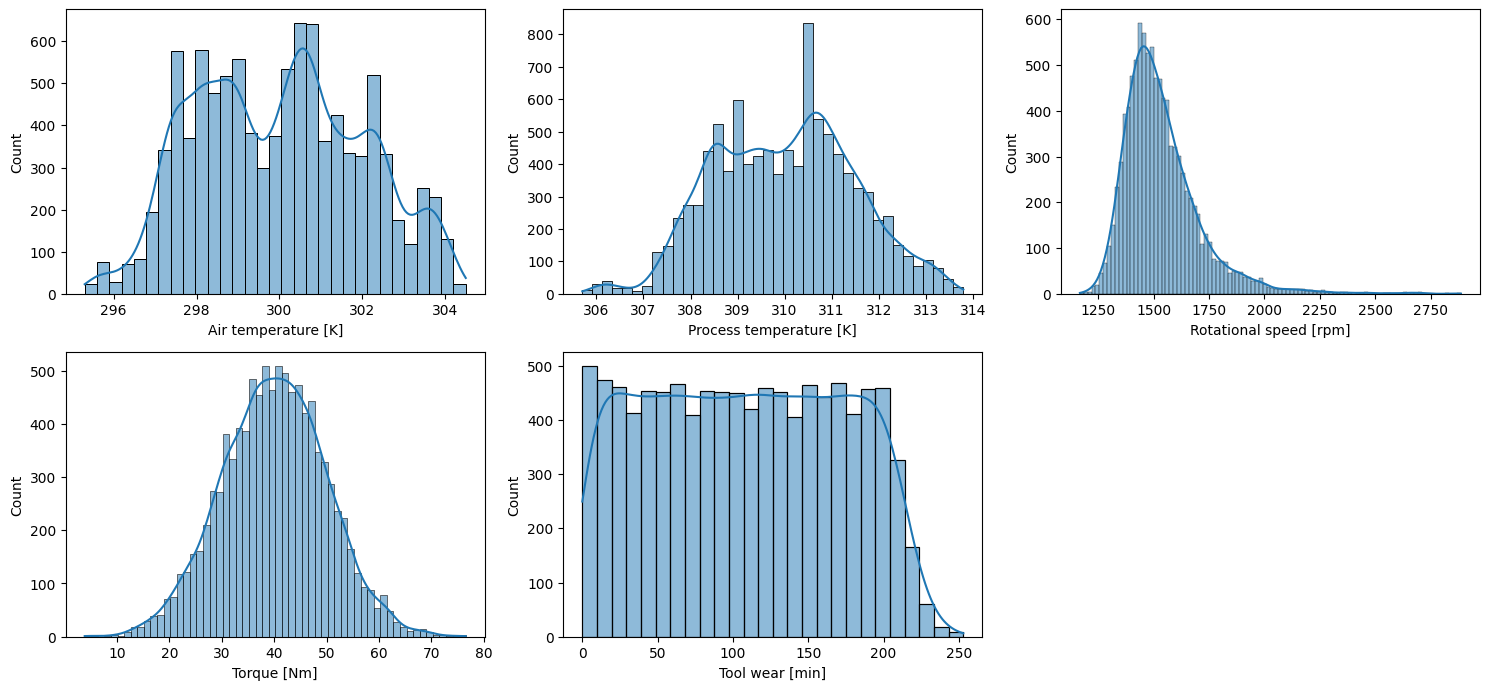

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=["number"])

# Correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap="RdYlBu")
plt.show()

# Histogram for each numeric column
numeric_df.hist(figsize=(16, 16))
plt.show()

# KDE plots for each numeric column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_df.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(numeric_df[col], kde=True)
plt.tight_layout()
plt.show()

## checking for missing value

In [5]:
# Check for missing values
missing_values = df.isnull().sum()

# Display columns with missing values (if any)
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print("Missing values found:\n", missing_values)
else:
    print("No missing values detected.")

# Optional: If there are missing values, fill or drop them
# df.fillna(df.mean(), inplace=True)  # Fill with mean (for numerical columns)
# df.dropna(inplace=True)  # Drop missing values (if needed)

No missing values detected.


## Encoding Categorical variables

In [6]:
print("Columns in DataFrame:", df.columns)

Columns in DataFrame: Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Failure Type'],
      dtype='object')


In [7]:
import pandas as pd

# Load dataset
file_path = "/mnt/data/predictive_maintenance.xlsx"
df = pd.read_csv('predictive_maintenance.csv')

# Print column names to check for any mismatches
print(df.columns)

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')


In [8]:
# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Encode Failure Type
df["Failure Type"].replace({
    "No Failure": 0,
    "Heat Dissipation Failure": 1,
    "Power Failure": 2,
    "Overstrain Failure": 3,
    "Tool Wear Failure": 4,
    "Random Failures": 5
}, inplace=True)

# Encode Machine Type
df["Type"].replace({
    "H": 0,
    "L": 1,
    "M": 2
}, inplace=True)

print("Categorical variables encoded successfully!")

Categorical variables encoded successfully!


## Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

# Defining the features (X) and target variable (y)
X = df.drop(columns=["Failure Type", "UDI", "Product ID", "Target"])  # Dropping unnecessary columns
y = df["Failure Type"]

# Splitting the dataset into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

print("Train-Test Split Successful!")
print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

Train-Test Split Successful!
Training Samples: 7000, Testing Samples: 3000


## Handling class Imbalance with SMOTE

In [10]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to balance the classes in the training data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("Class imbalance handled successfully!")
print(f"Resampled Training Samples: {X_res.shape[0]}")

Class imbalance handled successfully!
Resampled Training Samples: 40536


In [11]:
import pandas as pd

# Convert target variable to DataFrame for checking distribution
y_resampled_df = pd.DataFrame(y_res, columns=['Failure Type'])

# Print class distribution after SMOTE
print("Resampled Class Distribution:\n", y_resampled_df['Failure Type'].value_counts())

Resampled Class Distribution:
 Failure Type
0    6756
4    6756
3    6756
1    6756
2    6756
5    6756
Name: count, dtype: int64


## Feature Scaling

In [12]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the resampled training data
X_train_scaled = scaler.fit_transform(X_res)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

print("Feature scaling applied successfully!")

Feature scaling applied successfully!


In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: np.float64(0.1726860074995066), 1: np.float64(14.957264957264957), 2: np.float64(17.412935323383085), 3: np.float64(21.21212121212121), 4: np.float64(37.634408602150536), 5: np.float64(89.74358974358974)}


## Model Training (CatboostClassifier)

In [14]:
from catboost import CatBoostClassifier

# Initialize CatBoostClassifier with class weights
catb = CatBoostClassifier(random_seed=42, verbose=100, class_weights=list(class_weight_dict.values()))

# Train the model
catb.fit(X_train_scaled, y_res)

print("Model training completed successfully!")

Learning rate set to 0.09557
0:	learn: 1.4151133	total: 173ms	remaining: 2m 52s
100:	learn: 0.0148568	total: 2.27s	remaining: 20.2s
200:	learn: 0.0081890	total: 3.96s	remaining: 15.7s
300:	learn: 0.0061220	total: 5.57s	remaining: 12.9s
400:	learn: 0.0050834	total: 7.39s	remaining: 11s
500:	learn: 0.0042842	total: 9.29s	remaining: 9.25s
600:	learn: 0.0038272	total: 11.2s	remaining: 7.46s
700:	learn: 0.0035168	total: 13.2s	remaining: 5.63s
800:	learn: 0.0032747	total: 15.2s	remaining: 3.77s
900:	learn: 0.0030660	total: 17.1s	remaining: 1.88s
999:	learn: 0.0029257	total: 19.1s	remaining: 0us
Model training completed successfully!


## Model Evaluation(CatBoostClassifier)


🔹 Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.53      0.70      6756
           1       0.96      1.00      0.98      6756
           2       0.98      1.00      0.99      6756
           3       0.98      1.00      0.99      6756
           4       0.92      1.00      0.96      6756
           5       0.77      1.00      0.87      6756

    accuracy                           0.92     40536
   macro avg       0.94      0.92      0.91     40536
weighted avg       0.94      0.92      0.91     40536


✅ Training Balanced Accuracy Score: 92.23%
✅ Training Matthews Correlation Coefficient: 0.9116


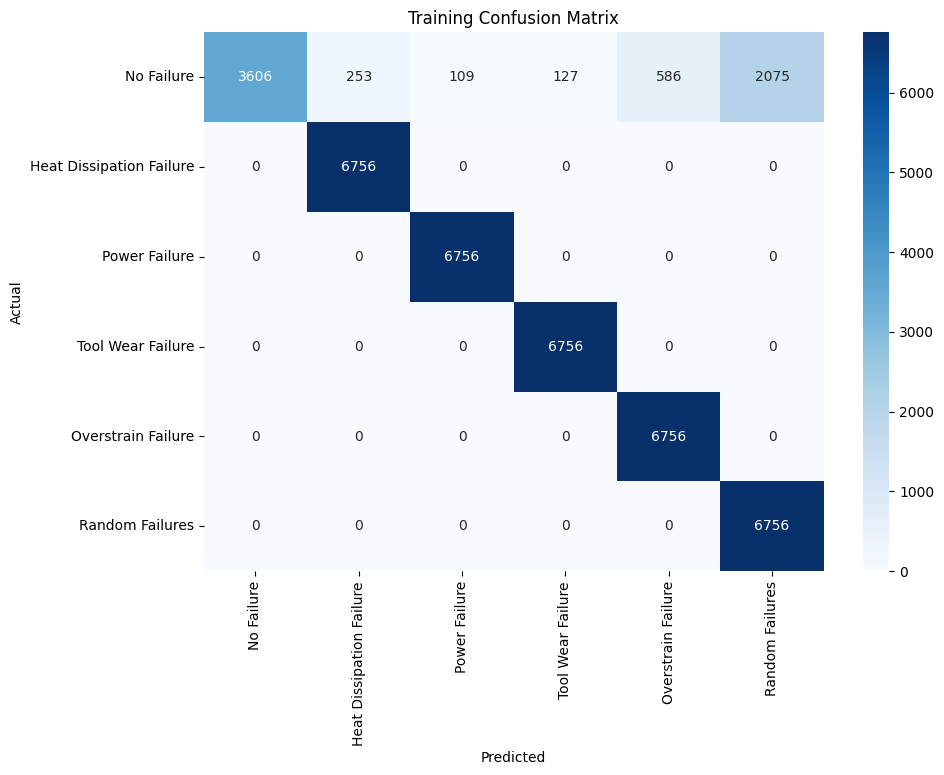

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Define failure type mapping
failure_mapping = {
    0: "No Failure",
    1: "Heat Dissipation Failure",
    2: "Power Failure",
    3: "Tool Wear Failure",
    4: "Overstrain Failure",
    5: "Random Failures"
}

# Predict on training data
y_train_pred = catb.predict(X_train_scaled)

# Calculate training metrics
train_balanced_acc = balanced_accuracy_score(y_res, y_train_pred)
train_mcc = matthews_corrcoef(y_res, y_train_pred)

# Print evaluation report
print("\n🔹 Training Classification Report:\n", classification_report(y_res, y_train_pred))
print(f"\n✅ Training Balanced Accuracy Score: {train_balanced_acc * 100:.2f}%")  # FIXED PERCENTAGE DISPLAY
print(f"✅ Training Matthews Correlation Coefficient: {train_mcc:.4f}")

# Plot the confusion matrix for training data
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_res, y_train_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=list(failure_mapping.values()), yticklabels=list(failure_mapping.values()))

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Training Confusion Matrix")
plt.show()

## Model Saving

In [16]:
import joblib

# Save the trained CatBoost model to a file
joblib.dump(catb, 'catboost_model.pkl')
print("CatBoost model saved successfully!")

CatBoost model saved successfully!


In [17]:
import joblib

# Save the scaler
joblib.dump(scaler, "scaler.pkl")

print("Scaler saved successfully!")

Scaler saved successfully!
